In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from skimage.transform import resize
from scipy import stats
from scipy import signal

from utils import Tail
from utils import find_onset_offset_numpy
from utils import diff_but_better
from utils import estimate_threshold_using_GMM
from utils import batch_tail_angle

from sporco import util
from sporco.admm import cbpdnin

In [ ]:
filelist = ['2021-10-07-nefma-7dpf-f1-all_logs']

Tensor = np.zeros((3500,10,0))
stop = False
df = pd.read_csv('D:\SCAPE\Data\RawData_csv\'+filelist[0]+'.csv')

NumSegment = 16

tail_angle = df[['angle'+str(i) for i in range(NumSegment)]]
tail_angle = tail_angle.values
tail_angle = np.cumsum(tail_angle,axis=1)
print(tail_angle.shape)
tail_angle = tail_angle[:,1:]
print(tail_angle.shape)

tail_angle = resize(tail_angle, (tail_angle.shape[0], 10),order=0) # 0 for nearest neighbor
tail = Tail(tail_angle)
tail.tail_angle_preprocessing()

tail_angle = tail.angle_smooth
tail_angle_detrend = np.zeros_like(tail_angle) 

for s in range(tail_angle.shape[1]):
    print(s)
    x = np.copy(tail_angle[:,s])
    # Compute tail active
    trend = signal.savgol_filter(x, window_length=31, polyorder=1, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
    detrend = np.abs(x-trend)
    x = pd.DataFrame({'x':detrend})
    win = 15
    x = x.rolling(win).mean().values[:,0]
    BT,ax = estimate_threshold_using_GMM(x,margin_std=2,axis=None)

    baseline = np.zeros_like(x)
    tail_active = (x>BT)
    #kernel = np.ones(40)
    #filtered_timeforward = np.convolve(kernel,tail_active, mode='full')[:tail_active.shape[0]] # Trick to make convolution causal
    #tail_active = 1.0*((filtered_timeforward)>0)#*filtered_timebackward)>0)

    baseline[tail_active==0]=tail_angle[tail_active==0,s]

    onset,offset,duration = find_onset_offset_numpy(tail_active)
    for on_,off_,dur_ in zip(onset,offset,duration):
        tmp = tail_angle[on_:off_,s]
        if dur_>1:
            baseline[on_:off_] = tmp[0]#np.linspace(tmp[0],tmp[-1],dur_)
        else:
            baseline[on_] = tail_angle[on_,s]

    if np.any(np.isnan(trend)):
        stop=True
        break
    tail_angle_detrend[:,s] = tail_angle[:,s]-baseline


(1266204, 16)
(1266204, 15)
0


C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])
C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])


1


C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])


2


C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])


3


C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])


4


C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])


5


C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\Elena\PycharmProjects\megabouts\megabouts\head_restrained\utils.py:152: RuntimeWarning: invalid value encountered in greater
  log_x = np.log(x[x>0])


6


# Using Free Swimming Optimized Dictionnary

In [21]:
Dict = np.load('fullDataset19atomsTu.npy')

id_forward = np.array([4, 12, 13, 14, 15, 17, 18])
id_fast = np.array([2, 5, 10])
id_turn = np.array([0, 1, 3, 8, 9, 16])
id_escape = np.array([6, 7, 11])


N_atoms = Dict.shape[2]

# First Option full mutual inhibition:
Wg = np.ones((1,N_atoms))

# Alternative Option inhibition between groups:

Wg = np.ones((4,19))

for i,list_ in enumerate([id_forward,id_fast,id_turn,id_escape]):
    for k in list_:
        Wg[i,k]=0


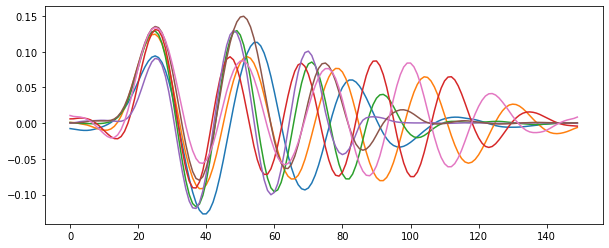

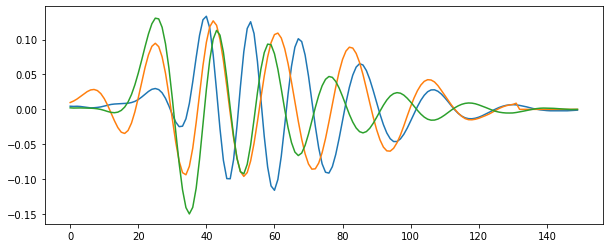

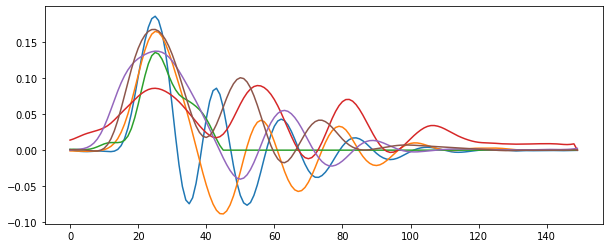

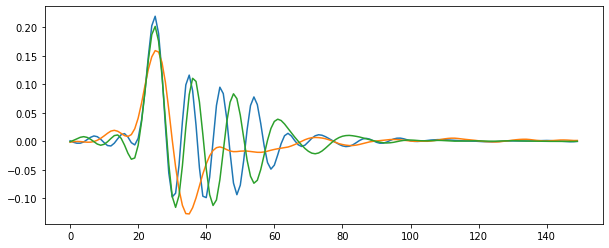

In [22]:
for list_ in [id_forward,id_fast,id_turn,id_escape]:
    plt.figure(figsize=(10,4))
    for i in list_:
        plt.plot(Dict[:,-1,i])


In [23]:
# Batch Dataset:
tail_angle_batch = batch_tail_angle(tail_angle_detrend[:,:7])

print(tail_angle_batch.shape)

T_trial = tail_angle_batch.shape[0]
N_Seg = tail_angle_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],tail_angle_batch,lmbda =0.01, Wg=Wg,gamma=0.,mu=0.05,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
tail_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:tail_angle_detrend.shape[0],:]
tail_angle_hat_ = np.zeros((tail_hat.shape[0]*tail_hat.shape[2],tail_hat.shape[1]))
for i in range(tail_hat.shape[1]):
    tail_angle_hat_[:,i] = tail_hat[:,i,:].T.flatten()
tail_angle_hat_ = tail_angle_hat_[:tail_angle_detrend.shape[0],:]



(21000, 7, 61)
Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------


In [ ]:
decomposition = np.zeros((z.shape[0],4))
for i,list_ in enumerate([id_forward,id_fast,id_turn,id_escape]):
    tmp = np.zeros(z.shape[0])
    for k in list_:
        decomposition[:,i] = decomposition[:,i]+np.convolve(z[:,k],Dict[:,-1,k],'full')[:z.shape[0]]


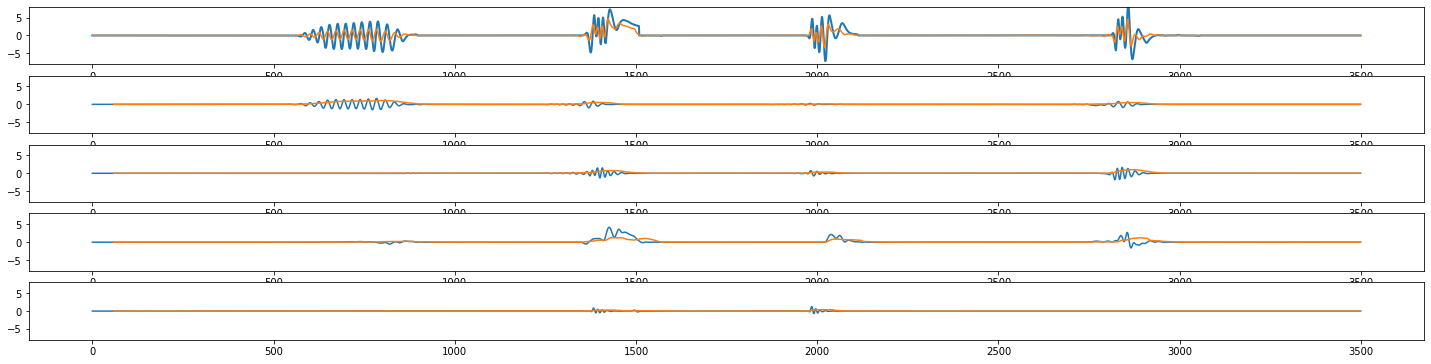

In [ ]:
import matplotlib.gridspec as gridspec

Duration = 700*5
IdSt = 943000#np.random.randint(decomposition.shape[0]-Duration)


fig, ax = plt.subplots(facecolor='white',figsize=(25,15)) 

G = gridspec.GridSpec(12,1)

ax = plt.subplot(G[0])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,-1],lw=2)
ax.plot(tail_angle_hat_[IdSt:IdSt+Duration,-1])
ax.set_ylim(-8,8)

for i in range(decomposition.shape[1]):
    ax = plt.subplot(G[i+1])
    tmp = decomposition[IdSt:IdSt+Duration,i]
    ax.plot(tmp)
    ts = pd.Series(tmp)
    # calculate a 60 day rolling mean and plot
    energy = ts.rolling(window=60).std()
    ax.plot(energy.values)
    ax.set_ylim(-8,8)
    #ax.set_xticks([])
plt.show()

# Using Bout Category as dictionnary

In [67]:
f = np.load('Dict_MarquesClusters.npz')
Dict = f['Dict']
NameCat = f['NameCat']
Wg = f['Wg']

In [68]:
Dict.shape

(120, 7, 22)

#### Run Sparse Coding

In [120]:
# Batch Dataset:
tail_angle_batch = batch_tail_angle(tail_angle_detrend[:,:7])

print(tail_angle_batch.shape)

N_atoms = Dict.shape[2]
T_trial = tail_angle_batch.shape[0]
N_Seg = tail_angle_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],tail_angle_batch,lmbda =0.01, Wg=Wg,gamma=0.,mu=0.1,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
tail_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:tail_angle_detrend.shape[0],:]
tail_angle_hat_ = np.zeros((tail_hat.shape[0]*tail_hat.shape[2],tail_hat.shape[1]))
for i in range(tail_hat.shape[1]):
    tail_angle_hat_[:,i] = tail_hat[:,i,:].T.flatten()
tail_angle_hat_ = tail_angle_hat_[:tail_angle_detrend.shape[0],:]



(21000, 7, 61)
Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  5.03e+05  5.57e+03  5.45e+04  4.97e+06  0.00e+00  4.32e-01  1.85e+01  1.50e+00
   1  1.34e+06  4.21e+03  6.54e+04  1.33e+07  0.00e+00  1.00e+00  1.64e+00  1.50e+00
   2  1.57e+06  9.17e+03  6.01e+04  1.56e+07  0.00e+00  1.00e+00  0.00e+00  1.14e+00
   3  3.71e+05  2.36e+05  5.23e+03  1.35e+06  0.00e+00  7.16e-01  3.52e-01  1.14e+03
   4  3.63e+05  3.05e+05  2.48e+03  5.81e+05  0.00e+00  4.31e-01  2.64e-01  1.58e+03
   5  3.21e+05  2.79e+05  2.02e+03  4.28e+05  0.00e+00  2.13e-01  1.89e-01  1.97e+03
   6  3.25e+05  2.85e+05  2.04e+03  4.00e+05  0.00e+00  1.49e-01  2.85e-01  1.97e+03
   7  3.08e+05  2.65e+05  2.35e+03  4.31e+05  0.00e+00  1.39e-01  2.68e-01  1.39e+03
   8  3.12e+05  2.60e+05  2.98e+03  5.20e+05  0.00e+00  1.47e-01  3.34e-01  9.72e+02
   9  2.94e+05  2.32e+05  3.72e+03  6.21e+05  0.00

In [97]:
z.shape,Dict.shape,tail_angle_detrend.shape,Dict.shape

((1267073, 22), (120, 7, 22), (1267073, 10), (120, 7, 22))

In [121]:
decomposition = np.zeros((z.shape[0],11))
k = 0
for i in range(11):
    tmp1 = np.convolve(z[:,k],Dict[:,-1,k],'full')[:z.shape[0]]
    tmp2 =  np.convolve(z[:,k+1],Dict[:,-1,k+1],'full')[:z.shape[0]]
    decomposition[:,i] = tmp1+tmp2
    k = k+2

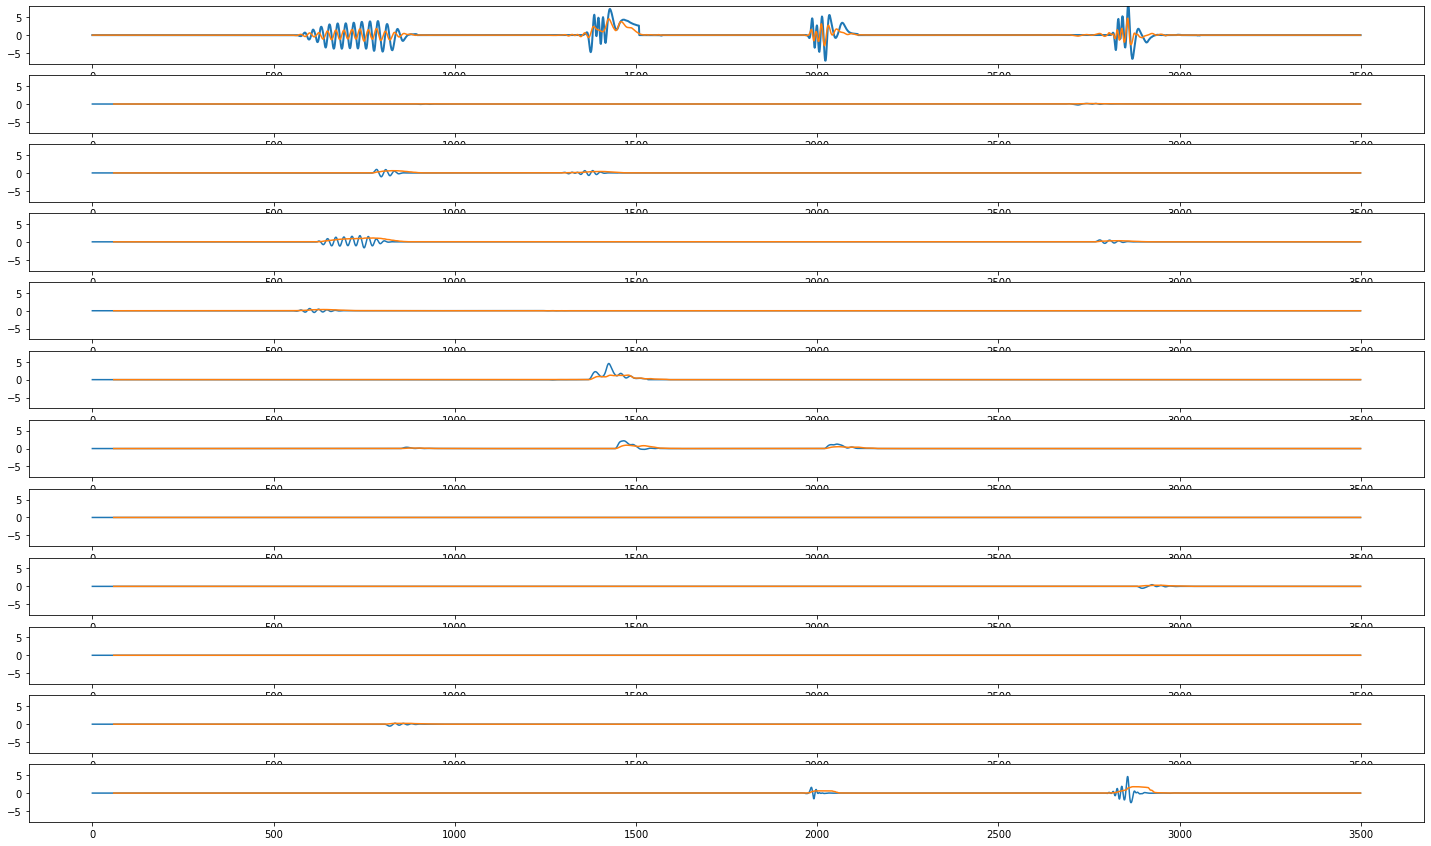

In [134]:
import matplotlib.gridspec as gridspec

Duration = 700*5
IdSt = 943000#np.random.randint(decomposition.shape[0]-Duration)


fig, ax = plt.subplots(facecolor='white',figsize=(25,15)) 

G = gridspec.GridSpec(12,1)

ax = plt.subplot(G[0])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,-1],lw=2)
ax.plot(tail_angle_hat_[IdSt:IdSt+Duration,-1])
ax.set_ylim(-8,8)

for i in range(decomposition.shape[1]):
    ax = plt.subplot(G[i+1])
    tmp = decomposition[IdSt:IdSt+Duration,i]
    ax.plot(tmp)
    ts = pd.Series(tmp)
    # calculate a 60 day rolling mean and plot
    energy = ts.rolling(window=60).std()
    ax.plot(energy.values)
    ax.set_ylim(-8,8)
    #ax.set_xticks([])
plt.show()

# Using Head Restrained Optimized Dict

In [142]:
f = np.load('Dict_OptimizedHeadRestrained.npz')
Dict = f['Dict']
id_forward = f['id_forward']
id_fast = f['id_fast']
id_turn = f['id_turn']
id_struggle = f['id_struggle']

N_atoms = Dict.shape[2]
Wg = np.ones((1,N_atoms))


In [143]:
Wg.shape

(1, 12)

In [144]:
Dict.shape

(150, 7, 12)

In [145]:
tail_angle_batch.shape

(21000, 7, 61)

In [146]:
# Batch Dataset:
tail_angle_batch = batch_tail_angle(tail_angle_detrend[:,:7])

print(tail_angle_batch.shape)

T_trial = tail_angle_batch.shape[0]
N_Seg = tail_angle_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],tail_angle_batch,lmbda =0.01, Wg=Wg,gamma=0.,mu=0.1,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
tail_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:tail_angle_detrend.shape[0],:]
tail_angle_hat_ = np.zeros((tail_hat.shape[0]*tail_hat.shape[2],tail_hat.shape[1]))
for i in range(tail_hat.shape[1]):
    tail_angle_hat_[:,i] = tail_hat[:,i,:].T.flatten()
tail_angle_hat_ = tail_angle_hat_[:tail_angle_detrend.shape[0],:]



(21000, 7, 61)
Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  8.00e+04  2.82e+03  6.68e+04  7.65e+05  0.00e+00  4.39e-01  3.76e+01  1.50e+00
   1  1.79e+05  1.34e+03  7.41e+04  1.77e+06  0.00e+00  9.84e-01  2.54e+00  1.50e+00
   2  2.37e+05  5.08e+03  7.48e+04  2.31e+06  0.00e+00  9.74e-01  5.03e-02  9.09e-01
   3  2.23e+05  1.87e+04  5.08e+04  2.03e+06  0.00e+00  6.88e-01  3.34e-01  3.90e+00
   4  1.80e+05  3.61e+04  3.81e+04  1.44e+06  0.00e+00  2.38e-01  3.63e-01  5.44e+00
   5  2.04e+05  3.38e+04  4.13e+04  1.70e+06  0.00e+00  1.91e-01  1.99e-01  4.30e+00
   6  1.82e+05  3.05e+04  3.73e+04  1.51e+06  0.00e+00  1.60e-01  1.55e-01  4.30e+00
   7  1.70e+05  3.30e+04  3.42e+04  1.37e+06  0.00e+00  1.37e-01  1.08e-01  4.30e+00
   8  1.61e+05  3.60e+04  3.24e+04  1.25e+06  0.00e+00  9.65e-02  9.02e-02  4.71e+00
   9  1.58e+05  3.61e+04  3.21e+04  1.22e+06  0.00

In [147]:
decomposition = np.zeros((z.shape[0],4))
for i,list_ in enumerate([id_forward,id_fast,id_turn,id_struggle]):
    tmp = np.zeros(z.shape[0])
    for k in list_:
        decomposition[:,i] = decomposition[:,i]+np.convolve(z[:,k],Dict[:,-1,k],'full')[:z.shape[0]]


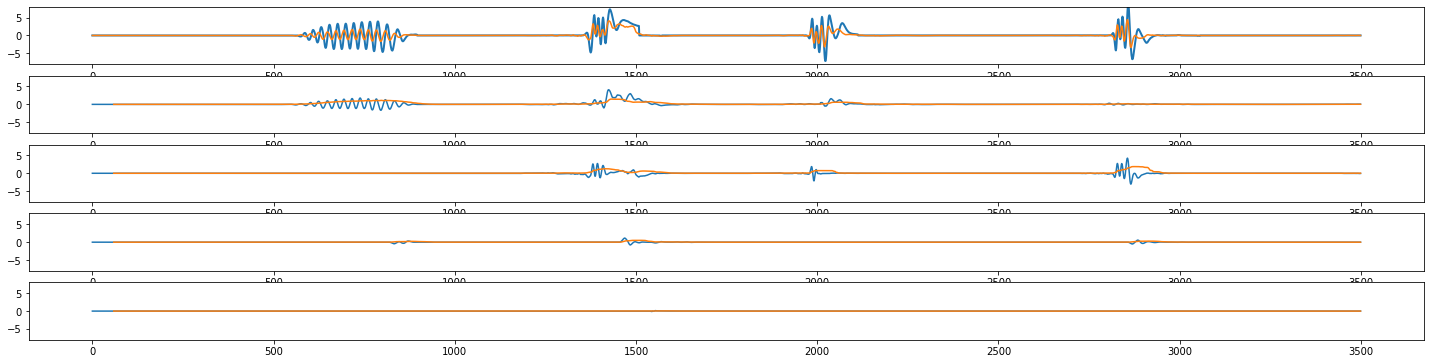

In [149]:
import matplotlib.gridspec as gridspec

Duration = 700*5
IdSt = 943000#np.random.randint(decomposition.shape[0]-Duration)


fig, ax = plt.subplots(facecolor='white',figsize=(25,15)) 

G = gridspec.GridSpec(12,1)

ax = plt.subplot(G[0])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,-1],lw=2)
ax.plot(tail_angle_hat_[IdSt:IdSt+Duration,-1])
ax.set_ylim(-8,8)

for i in range(decomposition.shape[1]):
    ax = plt.subplot(G[i+1])
    tmp = decomposition[IdSt:IdSt+Duration,i]
    ax.plot(tmp)
    ts = pd.Series(tmp)
    # calculate a 60 day rolling mean and plot
    energy = ts.rolling(window=60).std()
    ax.plot(energy.values)
    ax.set_ylim(-8,8)
    #ax.set_xticks([])
plt.show()